In [1]:
import pandas as pd
import numpy as np

import requests
from urllib.parse import urlencode

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import pingouin as pg

## Загрузка файлов и EDA

In [2]:
# функция для получения ссылки на скачивания через API
def get_url(link):
    public_key = link
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

 - **groups** - таблица с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [3]:
groups = pd.read_csv(get_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
groups.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [4]:
# проверю количество строк, пустые значения и типы данных в столбцах
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
# проверю повторы
groups.duplicated().sum()

0

- **active_studs** - таблица с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [6]:
active_studs = pd.read_csv(get_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [7]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [8]:
active_studs.duplicated().sum()

0

In [9]:
# проверю, всем ли активным назначена группа, т. е. все ли активные студенты есть в таблице groups
active_studs.student_id.isin(groups.id).value_counts()

student_id
True     8328
False      13
Name: count, dtype: int64

13-ти активным студентов не присвоена группа. Необходимо выяснить, по какой причине так собрали данные, а пока в расчетах их учитывать не буду. 

- **checks** - таблица с информацией об оплатах пользователей в дни проведения эксперимента

In [10]:
checks = pd.read_csv(get_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')
checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [11]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [12]:
checks.duplicated().sum()

0

In [13]:
# проверю, есть ли в таблице пользователи, совершавшие покупки несколько раз
checks.student_id.nunique()

541

! все платящие пользователи уникальны, т.е. совершили только одну покупку

In [14]:
# проверю, все ли платящие id есть в активных студентах
checks.student_id.isin(active_studs.student_id).value_counts()

student_id
True     392
False    149
Name: count, dtype: int64

149 платящих студентов были не активны в дни проведения экперимента, хотя их оплаты зафиксировались. Возможно, это ошибка сбора данных или автоплатежи. Их тоже не учитываю при расчетах. 

## А/В тестирование

In [15]:
# в таблице groups переименую колонку с id, чтобы соединить таблицы по этой колонке
groups = groups.rename(columns={'id':'student_id'})

In [16]:
# теперь соединю все таблицы в одну
exp_data = active_studs\
    .merge(groups, on='student_id')\
    .merge(checks, on='student_id', how='left')  # использую left join чтобы оставить только оплаты с активностью
exp_data.head(3)

,student_id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN


In [17]:
exp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8328 non-null   int64  
 1   grp         8328 non-null   object 
 2   rev         391 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 195.3+ KB


! В итоговой таблице остались только активные пользователи, которым присвоена группа: 13 студентов без группы не вошли в итоговую таблицу и общее количество студентов сократилось с 8341 до 8328.


! Так как основой является таблица **active_studs**, в итоговую таблицу попали _только активные студенты и их оплаты_, и 149 оплат от неактивных студентов не будут использованы для дальнейших расчетов.

In [18]:
# # проверю как различаются группы по количеству студентов
exp_data.grp.value_counts()

grp
B    6793
A    1535
Name: count, dtype: int64

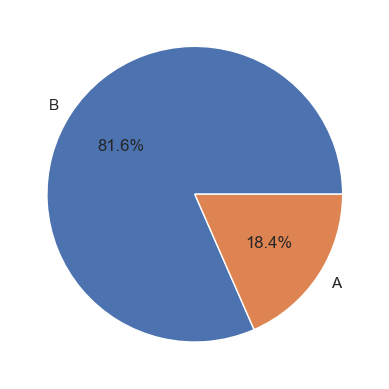

In [19]:
labels = list(dict(exp_data.grp.value_counts()).keys())
sizes = list(dict(exp_data.grp.value_counts()).values())

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    
plt.show()

### Расчет метрик

Для того, чтобы понять, увеличилось ли количество покупок между группами, можно сравнить метрику 
- **CR** (конверсия в покупателя, %):

$$
CR = \frac {количество\:юзеров, совершивших\:покупку} {количество\:активных\:юзеров} \times 100
$$

Также необходимо оценить различия в доходе с каждой группе. Так как численность групп не одинакова и напрямую доход мы сравнивать не можем, на мой взгляд, целесообразно использовать метрики:
 - **ARPPU** (средний доход на платящего пользователя, в д.е.) - в данном случае эта метрика фактически является средним чеком, так как все платящие пользователи и совершали покупку только один раз
 
 $$
 ARPPU = \dfrac{доход}{количество\:юзеров, совершивших\:покупку}
 $$
 
 - **ARPAU** (средний доход на активного пользователя, в д.е.)
  
 $$
 ARPAU = \dfrac{доход}{количество\:активных\:юзеров}
 $$

In [20]:
# считаю количество пользователей (users) и покупателей (clients) в группах
metrics = exp_data\
    .groupby('grp', as_index=False)\
    .agg({'student_id':'nunique','rev':'count'})\
    .rename(columns={'student_id':'users', 'rev':'clients'})
metrics

,grp,users,clients
0,A,1535,78
1,B,6793,313


In [21]:
# аналогичным способом считаю доход в группах
revenue = exp_data\
    .groupby('grp', as_index=False)\
    .agg({'rev':'sum'})\
    .rename(columns={'rev':'revenue'})\
    .round(2)
revenue

,grp,revenue
0,A,72820.0
1,B,393074.0


In [22]:
# соединяю расчеты
metrics = metrics.merge(revenue, on='grp')
metrics

,grp,users,clients,revenue
0,A,1535,78,72820.0
1,B,6793,313,393074.0


In [23]:
# вычисляю необходимые метрики
metrics['CR'] = round(100 * metrics.clients / metrics.users, 2)
metrics['ARPPU'] = round(metrics.revenue / metrics.clients, 2)
metrics['ARPAU'] = round(metrics.revenue / metrics.users, 2)

In [24]:
metrics

,grp,users,clients,revenue,CR,ARPPU,ARPAU
0,A,1535,78,72820.0,5.08,933.59,47.44
1,B,6793,313,393074.0,4.61,1255.83,57.86


In [25]:
# функция для построения графиков по расчетным метрикам
def show_metrics(metrics):
    fig, axs = plt.subplots(1, 3, figsize = (12, 5))
    sns.color_palette("Set2")
    
    cr = sns.barplot(ax=axs[0], data=metrics, x='grp', y='CR', hue='grp')
    cr.set(xlabel='', ylabel='', title = 'CR')
    
    arppu = sns.barplot(ax=axs[1], data=metrics, x='grp', y='ARPPU', hue='grp')
    arppu.set(xlabel='', ylabel='', title = 'ARPPU')
    
    arpau = sns.barplot(ax=axs[2], data=metrics, x='grp', y='ARPAU', hue='grp')
    arpau.set(xlabel='', ylabel='', title = 'ARPAU')

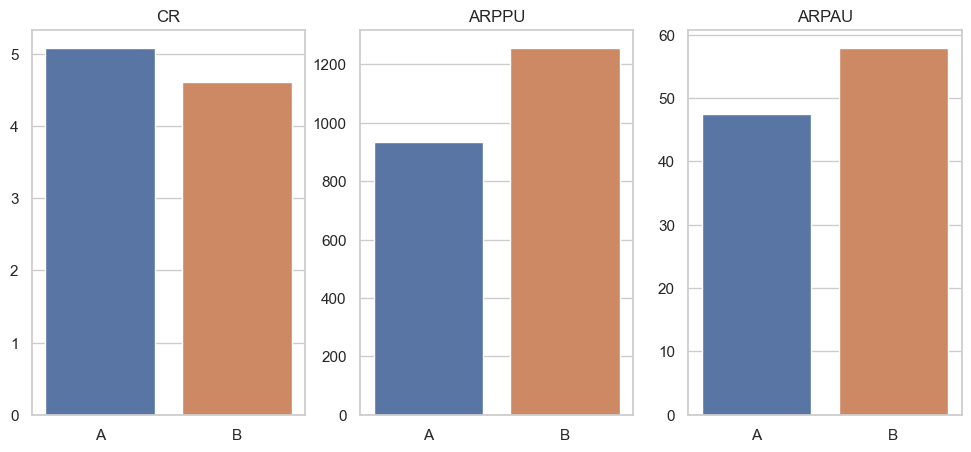

In [26]:
show_metrics(metrics)

Итак, в экспериментальной группе (B) наблюдаются следующие эффекты:
- уменьшение метрики **CR**
- увеличение метрик **ARPPU** и **ARPAU**

### Статистическая значимость

#### CR
Для расчета CR используются категориальные данные (оплатил/не оплатил), поэтому применяю критерий независимости Хи-квадрат.
- H0: распределение категориальной переменной не зависит от группы

In [27]:
# сначала добавлю в итоговую таблицу столбец 'payed' с категориальной переменной
exp_data['payed'] = exp_data.apply(lambda x: 0 if pd.isna(x['rev']) else 1, axis=1)

In [28]:
exp_data.head()

,student_id,grp,rev,payed
0,581585,A,NaN,0
1,3276743,B,NaN,0
2,4238589,A,NaN,0
3,4475369,B,NaN,0
4,5481015,B,NaN,0


In [29]:
# тест Хи-квадрат, нас интересует p-value по методу Пирсона
pg.chi2_independence(exp_data, x='grp', y='payed')

(payed            0           1
 grp                           
 A      1462.931676   72.068324
 B      6474.068324  318.931676,
 payed       0      1
 grp                 
 A      1457.5   77.5
 B      6479.5  313.5,
                  test    lambda      chi2  dof      pval    cramer     power
 0             pearson  1.000000  0.526607  1.0  0.468037  0.007952  0.112168
 1        cressie-read  0.666667  0.523446  1.0  0.469375  0.007928  0.111786
 2      log-likelihood  0.000000  0.517247  1.0  0.472019  0.007881  0.111037
 3       freeman-tukey -0.500000  0.512702  1.0  0.473971  0.007846  0.110488
 4  mod-log-likelihood -1.000000  0.508246  1.0  0.475899  0.007812  0.109950
 5              neyman -2.000000  0.499590  1.0  0.479680  0.007745  0.108905)

P-value (0.47) > 0.05. 

Следовательно, H0 отклонить не можем, и **различия в CR в группах нельзя считать статзначимыми**.

#### ARPPU и ARPAU

Так как для расчета обеих этих метрик используется средний доход, необходимо сравнить его распреденение в группах.

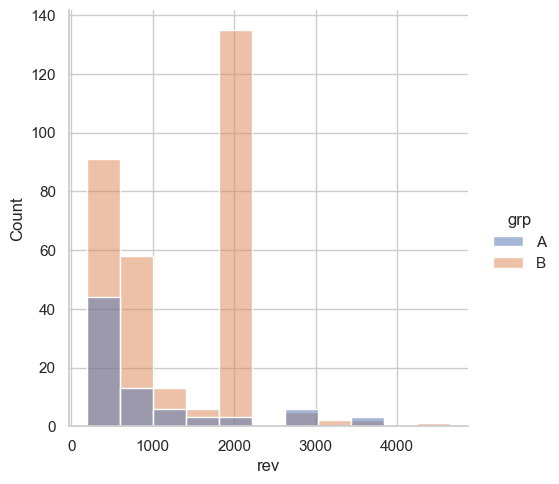

In [30]:
# смотрю распределение дохода в группах
sns.displot(exp_data, x='rev', hue='grp')

Видно, что в целевой группе наблюдается дополнительный пик, а значит, и смещение среднего дохода в большую сторону. Нужно проверить статзначимость этого изменения. 

Для попраного сравнения средних в независимых группах подходит **Критерий Стьюдента** (t-test), но для его применения должны выполняться требования к нормальности распределения выборок и гомогенности их диспресий. 

In [31]:
# проверю распределение на гомогенность дисперсии при помощи теста Левене.
pg.homoscedasticity(exp_data.fillna(0), dv='rev', group='grp', method='levene')

,W,pval,equal_var
levene,1.423391,0.23288,True


Так как количество наблюдений в обоих группах большое (> 30), требованием нормальности распределения можно пренебречь и применить t-test для попарных сравнений.
- H0: различий между средним доходом в группах нет 
- H1: средний доход в двух группах значимо различается

In [32]:
pg.pairwise_tests (data=exp_data, dv='rev', between='grp')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,grp,A,B,False,True,-2.842642,107.11348,two-sided,0.005359,6.213,-0.392999


P-value < 0,05, значит, мы можем отклонить H0 и сделать вывод о статистической значимости увеличения среднего дохода в группе B.

### Вывод:
Доход в целевой группе вырос не за счет конверсии в покупателя, а за счет того, что покупатели стали платить больше. Таким образом можно сделать вывод, что **новая механика упрощает процесс оплаты** и ее можно рекомендовать для запуска на всех пользователей.